# Modelling 

The goal is to obtain the traffic model that gives the covariance kernel its shape.

The first model is: $x_k = x_0 + k v_0 + \frac{2n-1}{2} \epsilon$. This corresponds to the model where $x_{k+1} = x_k + v_{k+1}$ and $v_{k+1} = v_k + \epsilon$ where $\epsilon \sim \mathcal{N}(0,\sigma_\epsilon^2)$ i.e., i.i.d. acceleration model.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt 

from scipy.stats import norm

%matplotlib inline 

In [2]:
def step(xk, vk):
    ak_plus_1 = norm.rvs(loc = 0, scale = 0.02)
    vk_plus_1 = vk + ak_plus_1
    xk_plus_1 = xk + vk_plus_1
    return (xk_plus_1, vk_plus_1)

In [3]:
num_of_trajs = 200
length_of_trajs = 270
trajs = np.zeros((num_of_trajs, length_of_trajs))
trajs_v = np.zeros((num_of_trajs, length_of_trajs))
for i in range(num_of_trajs):
    xk = 0
    vk = 0
    for j in range(length_of_trajs):
        new_xk, new_vk = step(xk, vk)
        trajs[i,j] = new_xk
        trajs_v[i,j] = new_vk
        xk = new_xk
        vk = new_vk

The trajectory should be integral of a Wiener process:

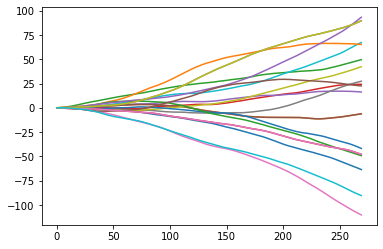

In [4]:
for i in np.random.choice(num_of_trajs, 20):
    plt.plot(trajs[i,:])

The velocity, since being integration of normal i.i.d. random variable, should be a Wiener process:

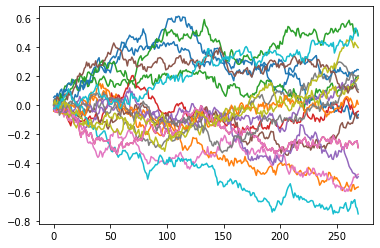

In [5]:
for i in np.random.choice(num_of_trajs, 20):
    plt.plot(trajs_v[i,:])

Let's find the covariance matrix:

In [6]:
import skfda
fdgr = skfda.FDataGrid(trajs, np.arange(trajs.shape[1]))
cov_mtrx = fdgr.cov().data_matrix[0,:,:,0]

(-0.5, 269.5, 269.5, -0.5)

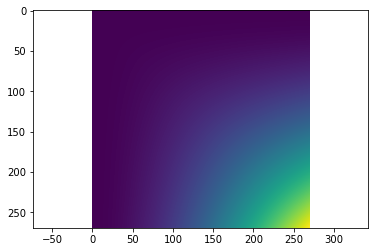

In [7]:
plt.imshow(cov_mtrx)
plt.axis('equal')

(0.0, 269.0, 0.0, 269.0)

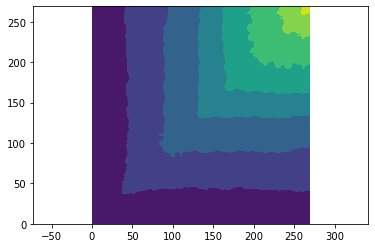

In [8]:
fdgrv = skfda.FDataGrid(trajs_v, np.arange(trajs_v.shape[1]))
cov_mtrxv = fdgrv.cov().data_matrix[0,:270,:270,0]
plt.contourf(cov_mtrxv)
plt.axis('equal')

# Creating the covariance matrix from analytical formula

(0.0, 999.0, 0.0, 999.0)

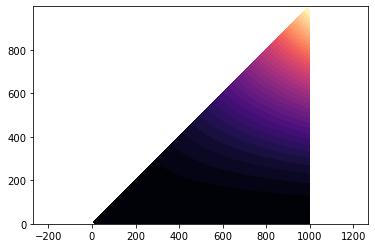

In [26]:
N = 1000
cov_anal = np.zeros((N,N))

for k in range(N):
    for j in range(k,N):
        cov_anal[k,j] = 1/2 * k * (k+1) * (np.abs(j-k) + 1/3 * (2*k+1))
        # cov_anal[k,j] = 1/2 * k * (k+1) * (np.abs(j-k))
# now cov_anal is upper-triangle
# cov_anal = cov_anal + cov_anal.T - np.diag(cov_anal.diagonal())
plt.contourf(cov_anal, cmap='magma', levels=np.arange(100, np.max(cov_anal), np.max(cov_anal)/40))
plt.axis('equal')

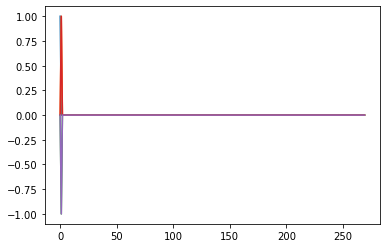

In [11]:
l,v = np.linalg.eig(cov_anal)
for i in range(5):
    plt.plot(v[:,i])

So we have obtained again, the "same" basis. Finding the eigenvectors numerically could be straightforward, but analytical results seem far fetched. The question is now can we approximate this thing via:

a) A manageable matrix after approximated, or

b) Asymptotic convergence.

In [12]:
T = np.zeros_like(cov_anal)
for row in range(N):
    for j in range(row, N):
        T[row,j] = j-row
# now T is upper-triangle
# T = T + T.T - np.diag(T) # make the matrix symmetric

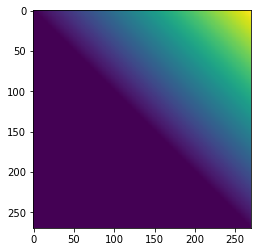

In [13]:
plt.imshow(T, interpolation='nearest')

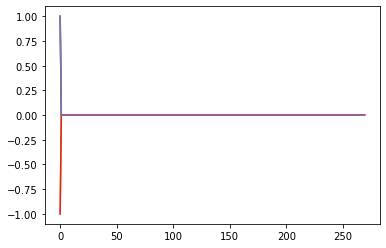

In [14]:
lt,vt = np.linalg.eig(T)
for i in range(5):
    plt.plot(vt[:,i])

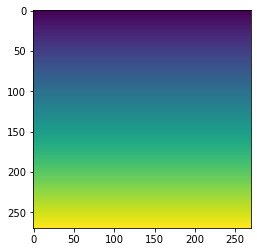

In [15]:
W = np.zeros_like(cov_anal)
for row in range(N):
    for j in range(N):
        W[row,j] = 2 * (row + 1) + 1 
plt.imshow(W, interpolation='nearest')

 /Users/thinhhoang/miniforge3/envs/liberty/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning:Casting complex values to real discards the imaginary part
 /Users/thinhhoang/miniforge3/envs/liberty/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning:Casting complex values to real discards the imaginary part
 /Users/thinhhoang/miniforge3/envs/liberty/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning:Casting complex values to real discards the imaginary part
 /Users/thinhhoang/miniforge3/envs/liberty/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning:Casting complex values to real discards the imaginary part
 /Users/thinhhoang/miniforge3/envs/liberty/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning:Casting complex values to real discards the imaginary part


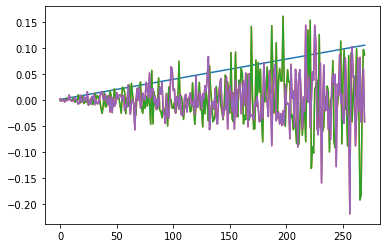

In [16]:
lw,vw = np.linalg.eig(W)
for i in range(5):
    plt.plot(vw[:,i])

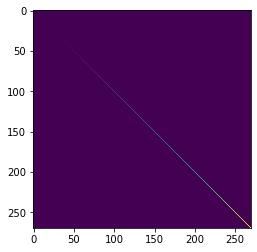

In [17]:
G = np.zeros((N,))
for i in range(1,N+1):
    G[i-1] = i * (i+1)
G = np.diag(G)
plt.imshow(G, interpolation='nearest')

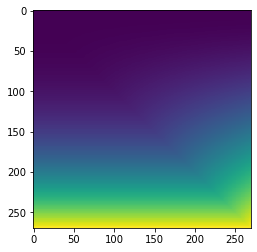

In [18]:
plt.imshow(G @ (T + W/3), interpolation='nearest')